<a href="https://colab.research.google.com/github/SifaMansuri/Final-Tweeteval/blob/main/final_project_emotion_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings 
warnings.filterwarnings('ignore')
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)
import plotly.graph_objs as go
import cufflinks
pd.options.display.max_columns = 30
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()
from collections import Counter
from pprint import pprint
import en_core_web_sm

In [ ]:
TRAIN_TEXT = 'https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/train_text.txt'
VAL_TEXT = 'https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/val_text.txt'

TRAIN_LABEL = 'https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/train_labels.txt'
VAL_LABEL = 'https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/val_labels.txt'


In [ ]:
def convert_to_df(data, label):
    tweet = []
    sentiments = []
    for sentence in data.split('\n'):
        tweet.append(sentence)
    for sentiment in label.split('\n'):
        try:
            sentiments.append(int(sentiment))
        except ValueError:
            pass
    df= pd.DataFrame(tweet[:-1], columns=['Review Text'])
    df['label'] = sentiments # this colums contains labels in int format

    df['sentiment'] = df.label.apply(lambda x: 'Not-emotion'if x==0 else 'emotion')

    return df

In [ ]:
import requests
train_tweets_txt = requests.get(TRAIN_TEXT).text
train_labels_txt = requests.get(TRAIN_LABEL).text

val_tweets_txt = requests.get(VAL_TEXT).text
val_labels_txt = requests.get(VAL_LABEL).text

train_df = convert_to_df(train_tweets_txt, train_labels_txt)
val_df = convert_to_df(val_tweets_txt, val_labels_txt)



In [ ]:
df = train_df

([<matplotlib.patches.Wedge at 0x7f7e938ed9d0>,
 [Text(-0.2404855872465183, 1.0733902749357744, 'emotion'),
  Text(0.24048558724651864, -1.0733902749357744, 'Not-emotion')],
 [Text(-0.13117395667991905, 0.5854856045104223, '57.0%'),
  Text(0.13117395667991924, -0.5854856045104223, '43.0%')])

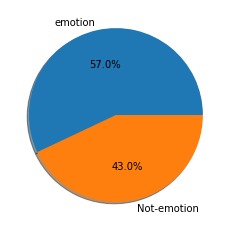

In [ ]:
eda = df.groupby('sentiment').count()['Review Text'].reset_index().sort_values(by='Review Text',ascending=False)
labels = list(eda.sentiment)
sizes = list(eda['Review Text'])

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)
plt.show()

In [ ]:
def preprocess(ReviewText):
    ReviewText = ReviewText.str.replace("(<br/>)", "")
    ReviewText = ReviewText.str.replace('(<a).*(>).*(</a>)', '')
    ReviewText = ReviewText.str.replace('(&amp)', '')
    ReviewText = ReviewText.str.replace('(&gt)', '')
    ReviewText = ReviewText.str.replace('(&lt)', '')
    ReviewText = ReviewText.str.replace('(\xa0)', ' ')  
    return ReviewText
df['Review Text'] = preprocess(df['Review Text'])

New column for sentiment polarity. Two new columns for lengths of the review and word count.

In [ ]:
df['polarity'] = df['Review Text'].map(lambda text: TextBlob(text).sentiment.polarity)
df['review_len'] = df['Review Text'].astype(str).apply(len)
df['word_count'] = df['Review Text'].apply(lambda x: len(str(x).split()))

In [ ]:
print('5 random reviews with the highest positive sentiment polarity: \n')
cl = df.loc[df.polarity == 1, ['Review Text']].sample(5).values
for c in cl:
    print(c[0])

5 random reviews with the highest positive sentiment polarity: 

Boys Dm me pictures of your cocks! The best one will get uploaded! ☺️💦💦 #Cumtribute #dm  #snapchat #snapme #nudes #dickpic #cocktribute 
@user wonderful experience watching you yesterday at. @user thankyou for the  
This is the day You've made, \n\nLet us rehoi rejoice and be glad with all that I am. \n\n😊💖\n\n#aja \nGood morning!!!! 
@user Both Trump + King are relentless self-promoters who don't give a rip about anyone else. A perfect match for both Donalds. 
@user Thank you, happy birthday to you as well! 


In [ ]:
print('5 random reviews with the most neutral sentiment(zero) polarity: \n')
cl = df.loc[df.polarity == 0, ['Review Text']].sample(5).values
for c in cl:
    print(c[0])

5 random reviews with the most neutral sentiment(zero) polarity: 

schneiderlin taking his revenge for the 2 fouls 
something about opening mail is just...very pleasing 
Fuckin hell even seeing your face makes me fume 
@user did it not just enliven your soul 
Turkish exhilaration: for a 30% shade off irruptive russian visitors this twelvemonth, gobbler is nephalism so... 


### Dist plot of review polarity score

In [ ]:
df['polarity'].iplot(
    kind='hist',
    bins=50,
    xTitle='polarity',
    linecolor='black',
    yTitle='count',
    title='Sentiment Polarity Distribution')

Vast majority of the polarity are greater than 0, means most of them are positive.

### Distribution of ratings

The ratings are in align with the polarity, that is, most of the ratings are at 4 or 5 range.

### Reviewers age distribution

Most reviewers are in their 30s to 40s.

In [ ]:
df['review_len'].iplot(
    kind='hist',
    bins=100,
    xTitle='review length',
    linecolor='black',
    yTitle='count',
    title='Review Text Length Distribution')

### Top unigrams before removing stop words

In [ ]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(df['Review Text'], 20)
for word, freq in common_words:
    print(word, freq)
df1 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])

user 2019
the 1515
to 1208
and 885
you 739
is 738
of 671
it 645
in 569
that 525
my 497
for 417
on 379
me 353
this 300
so 295
with 295
just 280
not 277
be 270


### Top unigrams after removing stop words

In [ ]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(df['Review Text'], 20)
for word, freq in common_words:
    print(word, freq)
df2 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])

user 2019
just 280
like 228
don 204
people 141
know 99
think 97
sad 91
really 88
love 88
ve 87
time 86
day 86
got 83
life 77
want 77
good 75
going 74
today 73
ll 68


### Top bigrams before removing stop words

In [ ]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(df['Review Text'], 20)
for word, freq in common_words:
    print(word, freq)
df3 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])

user user 485
of the 99
in the 99
to be 77
on the 63
to the 61
for the 58
you re 56
at the 51
going to 49
if you 49
this is 47
is the 44
when you 40
want to 39
user it 37
to get 36
have to 36
in my 35
it was 35


In [ ]:
df3.groupby('ReviewText').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 bigrams in review before removing stop words')

### Top bigrams after removing stop words

In [ ]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(df['Review Text'], 20)
for word, freq in common_words:
    print(word, freq)
df4 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])

user user 499
user don 29
watch amazing 27
amazing live 27
live ly 27
ly broadcast 27
broadcast user 27
user just 25
don know 24
feel like 20
user musically 15
don think 15
just want 13
user ve 13
user oh 12
ve seen 12
happy birthday 12
user thanks 12
user lively 12
lively musically 12


In [ ]:
df4.groupby('ReviewText').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 bigrams in review after removing stop words')

### Top trigrams before removing stop words

In [ ]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(df['Review Text'], 20)
for word, freq in common_words:
    print(word, freq)
df5 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])

user user user 164
watch this amazing 27
this amazing live 27
amazing live ly 27
live ly broadcast 27
ly broadcast by 27
broadcast by user 27
by user musically 15
one of the 15
by user lively 12
user lively musically 12
going to be 10
you want to 9
is better than 8
user user the 8
know how to 8
can wait to 8
is going to 8
user user you 8
don know what 8


In [ ]:
df5.groupby('ReviewText').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 trigrams in review before removing stop words')

### Top trigrams after removing stop words

In [ ]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(df['Review Text'], 20)
for word, freq in common_words:
    print(word, freq)
df6 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])

user user user 165
watch amazing live 27
amazing live ly 27
live ly broadcast 27
ly broadcast user 27
broadcast user musically 15
broadcast user lively 12
user lively musically 12
user user don 8
hell hath fury 6
man did know 5
did know juggle 5
know juggle just 5
juggle just didn 5
just didn balls 5
didn balls funny 5
balls funny pun 5
hath fury like 5
user user wow 4
user don think 4


In [ ]:
df6.groupby('ReviewText').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 trigrams in review after removing stop words')

### Top 20 part-of-speech tagging of review corpus

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
blob = TextBlob(str(df['Review Text']))
pos_df = pd.DataFrame(blob.tags, columns = ['word' , 'pos'])
pos_df = pos_df.pos.value_counts()[:20]
pos_df.iplot(
    kind='bar',
    xTitle='POS',
    yTitle='count', 
    title='Top 20 Part-of-speech tagging for review corpus')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

### Topic Modeling with LSA

In [ ]:
reindexed_data = df['Review Text']
tfidf_vectorizer = TfidfVectorizer(stop_words='english', use_idf=True, smooth_idf=True)
reindexed_data = reindexed_data.values
document_term_matrix = tfidf_vectorizer.fit_transform(reindexed_data)

In [ ]:
n_topics = 6
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(document_term_matrix)

In [ ]:
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [ ]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [ ]:
def get_top_n_words(n, keys, document_term_matrix, tfidf_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = tfidf_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [ ]:
top_n_words_lsa = get_top_n_words(3, lsa_keys, document_term_matrix, tfidf_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

Topic 1:  user just shocking
Topic 2:  watch live amazing
Topic 3:  just want really
Topic 4:  don know user
Topic 5:  like depression feel
Topic 6:  people lost angry


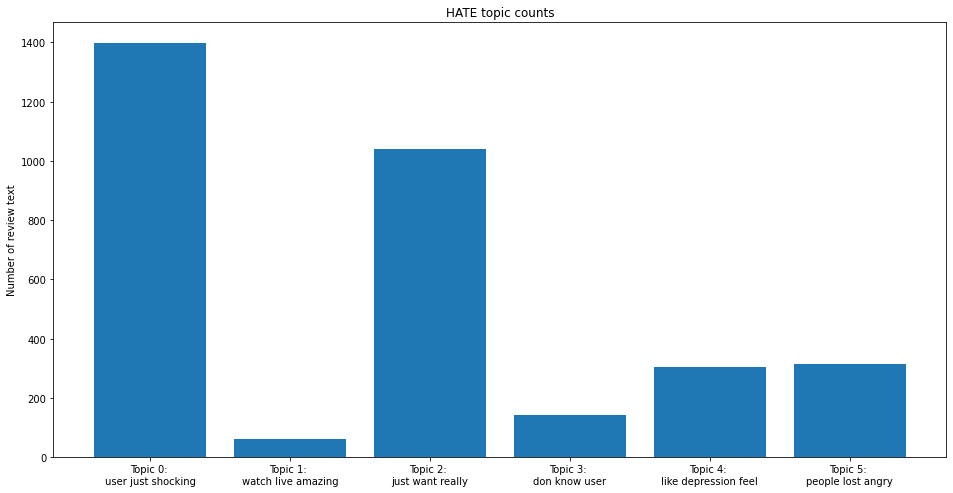

In [ ]:
top_3_words = get_top_n_words(3, lsa_keys, document_term_matrix, tfidf_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
ax.set_xticklabels(labels);
ax.set_ylabel('Number of review text');
ax.set_title('HATE topic counts');
plt.show();

In [ ]:
tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 3257 samples in 0.004s...
[t-SNE] Computed neighbors for 3257 samples in 0.208s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3257
[t-SNE] Computed conditional probabilities for sample 2000 / 3257
[t-SNE] Computed conditional probabilities for sample 3000 / 3257
[t-SNE] Computed conditional probabilities for sample 3257 / 3257
[t-SNE] Mean sigma: 0.009699
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.581795
[t-SNE] KL divergence after 2000 iterations: 0.811369


In [ ]:
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(n_topics):
        reviews_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                reviews_in_that_topic.append(two_dim_vectors[i])    
        
        reviews_in_that_topic = np.vstack(reviews_in_that_topic)
        mean_review_in_that_topic = np.mean(reviews_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_review_in_that_topic)
    return mean_topic_vectors

In [ ]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_topics]

In [ ]:
top_3_words_lsa = get_top_n_words(3, lsa_keys, document_term_matrix, tfidf_vectorizer)
lsa_mean_topic_vectors = get_mean_topic_vectors(lsa_keys, tsne_lsa_vectors)

plot = figure(title="t-SNE Clustering of {} LSA Topics".format(n_topics), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lsa_vectors[:,0], y=tsne_lsa_vectors[:,1], color=colormap[lsa_keys])

for t in range(n_topics):
    label = Label(x=lsa_mean_topic_vectors[t][0], y=lsa_mean_topic_vectors[t][1], 
                  text=top_3_words_lsa[t], text_color=colormap[t])
    plot.add_layout(label)
    
show(plot)

GlyphRenderer(id='1038', ...)

Here are the terms that differentiate the review text from a general English corpus.

Here are the terms in review text that are most associated with Tops department: